#**Heat Map Generation and Classification Metrics**

In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (129 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from openslide.deepzoom import DeepZoomGenerator

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn import metrics
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls '/content/drive/My Drive/ADL Project/model'

base_model_4_20.h5	      MobileNet_model_4_20_over.h5
base_model_4_20_over.h5       MobileNet_model_4_3_20_over.h5
Last_run_122020		      VGG16_model_4_20_over_fine.h5
MobileNet_model_3_20_over.h5  VGG16_model_4_20_over_pre.h5


##**1. Load Model**

In [5]:
IMG_path = '/content/drive/My Drive/ADL Project/Image'
MODEL_path = '/content/drive/My Drive/ADL Project/model'
model_name = '/MobileNet_model_3_20_over.h5'


In [6]:
model = models.load_model(MODEL_path + model_name)

##**2. Parameters**

In [7]:
path_dir_images = os.getcwd() + '/drive/My Drive/ADL Project/Images'
slide_path = path_dir_images +'/' +'tumor_' + '110'+'.tif'
tumor_mask_path = path_dir_images +'/' +'tumor_' + '110' +'_mask.tif'
lv = 4
tile_sz = 256
frame_sz = int(32 * 2)
tissue_threshold = 50

##**3. Heat Map Generation**

In [8]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
  
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))
  
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [9]:
slide = open_slide(slide_path)
slide_image = np.asarray(read_slide(slide, x=0, y=0, 
                         level=lv, 
                         width=slide.level_dimensions[lv][0], 
                         height=slide.level_dimensions[lv][1]))

tumor_mask = open_slide(tumor_mask_path)
mask_image = np.asarray(read_slide(tumor_mask, x=0, y=0, 
                          level=lv, 
                          width=slide.level_dimensions[lv][0], 
                          height=slide.level_dimensions[lv][1]))

mask_pred=np.zeros_like(mask_image[:,:,0])

In [10]:
%%time
loc = []
Pred = []
for i in range(0, slide.level_dimensions[lv][1] - tile_sz - frame_sz, frame_sz):  #(0, 256 - 96, 96)
    for j in range(0, slide.level_dimensions[lv][0] - tile_sz - frame_sz, frame_sz): #(0, 256 - 96, 96)

      tile = slide_image[i:i+tile_sz, j:j+tile_sz]

      tissue_pixels = find_tissue_pixels(tile)
      percent_tissue = len(tissue_pixels) / float(tile.shape[0] * tile.shape[1]) * 100

      tile_preprocess = tile / 1.0 # in case CNN / 255.0

      tile_batch = tf.expand_dims(tile_preprocess, axis=0)
      batch_pred = model.predict(tile_batch)
      Pred.append(batch_pred[0][0])
      loc.append([i,j])

      if percent_tissue >= tissue_threshold:
        Pred.append(batch_pred[0][0])
        loc.append([i,j])

CPU times: user 15min 46s, sys: 1min 41s, total: 17min 27s
Wall time: 6min 7s


In [11]:
mask_pred=np.zeros_like(mask_image[:,:,0])

for num, (x,y) in enumerate(loc):
  if Pred[num] < 0.5:
    mask_pred[x:x+tile_sz, y:y+tile_sz] = 0.
  else:
    mask_pred[x:x+tile_sz, y:y+tile_sz] = Pred[num] * 255.

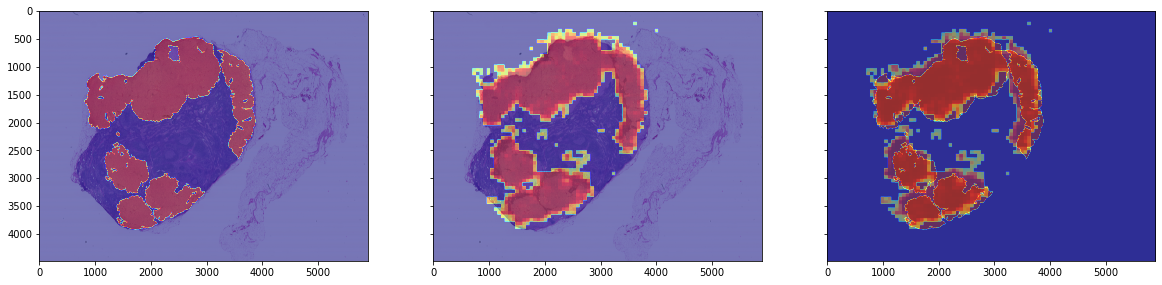

In [12]:
fig, ax = plt.subplots(1,3, figsize=(20, 20), sharey = True)

ax[0].imshow(slide_image)
ax[0].imshow(mask_image[:,:,0],cmap='jet', alpha=0.5)

ax[1].imshow(slide_image)
ax[1].imshow(mask_pred ,cmap='jet', alpha=0.5)

ax[2].imshow(mask_image[:,:,0], cmap='jet', alpha=0.7)
ax[2].imshow(mask_pred ,cmap='jet', alpha=0.4)

##**4. Evaluation Metrics**

In [13]:
mask_pred_flat = mask_pred.reshape(-1)
mask_image_flat = mask_image[:,:,0].reshape(-1)

mask_pred_flat = [1 if i/255 > 0.5 else 0 for i in mask_pred_flat]

In [14]:
ROC = roc_auc_score(mask_image_flat, mask_pred_flat)
tn, fp, fn, tp = confusion_matrix(mask_image_flat, mask_pred_flat).ravel()

print("ROC AUC score: ", ROC)
print("True Negative: %d" % tn)
print("False Positive: %d" % fp)
print("False Negative: %d" % fn)
print("True Positive: %d \n" % tp)

print(classification_report(mask_image_flat, mask_pred_flat, target_names=['No tumor', 'Tumor']))

ROC AUC score:  0.9087370286271221
True Negative: 20619264
False Positive: 1646721
False Negative: 446464
True Positive: 3665791 

              precision    recall  f1-score   support

    No tumor       0.98      0.93      0.95  22265985
       Tumor       0.69      0.89      0.78   4112255

    accuracy                           0.92  26378240
   macro avg       0.83      0.91      0.86  26378240
weighted avg       0.93      0.92      0.92  26378240

